In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
start_date = '2020-01-01'
end_date = '2023-01-01'

In [3]:
def RSIcalc(asset): #names
    df = yf.download(asset,start=start_date, end = end_date)
    df['MA200'] = df['Adj Close'].rolling(window=200).mean()
    df['Price Change'] = df['Adj Close'].pct_change()
    df['Upmove'] = df['Price Change'].apply(lambda x: x if x>0 else 0)
    df['Downmove'] = df['Price Change'].apply(lambda x: abs(x) if x<0 else 0)
    df['Avg Up'] = df["Upmove"].ewm(span=19).mean()
    df['Avg Down'] = df["Downmove"].ewm(span=19).mean()
    df = df.dropna()
    df['RS'] = (df['Avg Up']/df['Avg Down'])
    df['RSI']= df['RS'].apply(lambda x: 100-(100/(x+1)))
    df.loc[(df['Adj Close'] > df['MA200']) & (df['RSI']<50), 'Buy'] = 'Yes'
    df.loc[(df['Adj Close'] < df['MA200']) | (df['RSI']>50), 'Buy'] = 'No'
    return df

In [4]:
def getSignals(df):
    Buying_dates = []
    Selling_dates =[]
    
    for i in range(len(df)):
        if "Yes" in df['Buy'].iloc[i]:
            Buying_dates.append(df.iloc[i+1].name)

            for j in range(1,21):
                
                if (df['RSI'].iloc[i + j] > 60):
                    Selling_dates.append(df.iloc[i+j+1].name)
                    break
                    
                elif j==20:
                    Selling_dates.append(df.iloc[i+j+1].name)
            
                    
    return Buying_dates, Selling_dates    

In [5]:
def getSignals2(df, stop):
    Buying_dates = []
    Selling_dates =[]
    
    # Encontramos instantes en donde se indica la compra del activo, se mete a la lista de fechas
    for i in range(len(df)):
        if "Yes" in df['Buy'].iloc[i]:
            Buying_dates.append(df.iloc[i+1].name)
            
            # Revisamos los siguientes 10 dias a la compra el mercado
            for j in range(1,21):
                
                # la fecha en la que se compro
                flag = Buying_dates[-1]
                
                # la fecha de los siguientes 10 dias
                check = df.iloc[j].name
                
                # valor numerico de la accion en la fecha de compra
                precio_flag = df.loc[flag]['Open']
                
                # valor numerico de los 10 dias
                precio_check = df.loc[check]['Adj Close']
                
                # se revisa el cambio porcentual de la accion (se genera un 'Stop loss')
                porcentaje = (precio_check - precio_flag)/precio_check
                
                if ((df['RSI'].iloc[i + j] > 60) | (porcentaje < stop)):
                    Selling_dates.append(df.iloc[i+j+1].name)
                    break
                    
                elif j==20:
                    Selling_dates.append(df.iloc[i+j+1].name)
            
                    
    return Buying_dates, Selling_dates    

1. flag = ultimo dia de compra y su valor de cierre
2. check = Extrapolar precio de cierre del mismo dia y su cambio

## VARIOS ACTIVOS

[*********************100%***********************]  1 of 1 completed


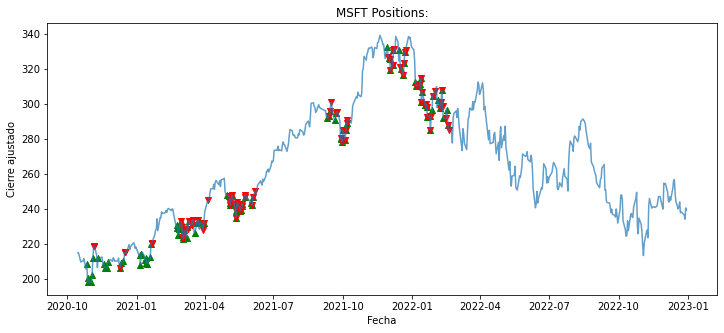

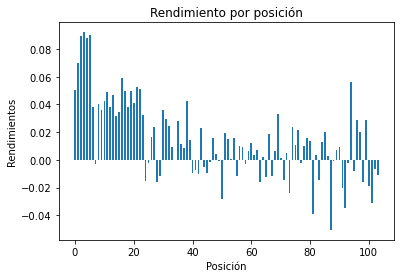

,Rendimientos,Utilidad,Monto
0,0.050428,0.047928,1047927.706
1,0.070256,0.067756,1118930.757
2,0.089136,0.086636,1215870.459
3,0.092187,0.089687,1324917.875
4,0.087963,0.085463,1438149.594
...,...,...,...
99,0.028614,0.026114,3485174.007
100,-0.018814,-0.021314,3410889.968
101,-0.031070,-0.033570,3296387.516
102,-0.006737,-0.009237,3265939.988


'Victorias: 0.663'

'Victoria promedio: 0.028'

'Perdida promedio: -0.014'

'Balance: 2899168.536'

'Utilidad: 1.899'

In [33]:
# Elegir activo:
stock = 'MSFT'

# Generar dataframe y calcular señales de compra:
frame = RSIcalc(stock)
#Buy, Sell = getSignals(frame)
Buy, Sell = getSignals2(frame, -0.1)

# Calcular retornos de estrategia
Profits = (frame.loc[Sell].Open.values - frame.loc[Buy].Open.values)/(frame.loc[Buy].Open.values)

# Delimitar costos de mercado y capital inicial
Comisiones = 0.0025
capital = 1000000

# Generar dataframe de retornos y utilidades
dfr = pd.DataFrame()
dfr['Rendimientos'] = Profits
dfr['Utilidad'] = dfr['Rendimientos']-Comisiones

# Generar columna de MONTO e INTERÉS COMPUESTO
Monto = [capital]

for i in range(len(dfr)):
    valor = Monto[-1]*(1+dfr['Utilidad'][i])
    Monto.append(valor)

    # se borra capital inicial de la lista de montos
del Monto[0]
dfr['Monto'] = np.round(Monto,3)

# Graficamos cierre de activo con fechas de compra:
plt.figure(figsize=(12,5))
plt.scatter(frame.loc[Buy].index , frame.loc[Buy]['Adj Close'], marker='^',c='g')
plt.scatter(frame.loc[Sell].index , frame.loc[Sell]['Adj Close'], marker='v',c='r')
plt.plot(frame['Adj Close'], alpha=0.7)
plt.xlabel('Fecha')
plt.ylabel('Cierre ajustado')
plt.title(str(stock)+ ' Positions:')
plt.show()

# Graficamos retorno generado por número de posición:
plt.bar(dfr.index, dfr.Rendimientos,width=0.6)
plt.xlabel("Posición")
plt.ylabel("Rendimientos")
plt.title("Rendimiento por posición")
plt.show()

# Calculamos el número de victorias en la estrategia:
wins = [i for i in Profits if i > 0]
avrg_win = np.mean(wins)
wins = len(wins)/len(Profits)

loss = [i for i in Profits if i < 0]
avrg_loss = np.mean(loss)

# Calculamos utilidad final DESPUÉS DE IMPUESTOS
impuestos = 0.1
    
    # Encontramos monto final
ultimo = dfr[['Monto']].iloc[-1]
    
    # Restamos impuestos
ultimo_MSFT = ultimo * (1-impuestos)
    
    # Lo convertimos en tasa comparado al capital inicial
utilidad_MSFT = (ultimo_MSFT - capital) / capital
    
# Mandamos todo a proyectar en la misma celda
display(dfr, 
        'Victorias: '+str(np.round(wins,3)),
        'Victoria promedio: ' +str(np.round(avrg_win,3)),
        'Perdida promedio: '+str(np.round(avrg_loss,3)),
        'Balance: '+str(np.round(ultimo_MSFT,3)[0]),
        'Utilidad: ' +str(np.round(utilidad_MSFT,3)[0]))

[*********************100%***********************]  1 of 1 completed


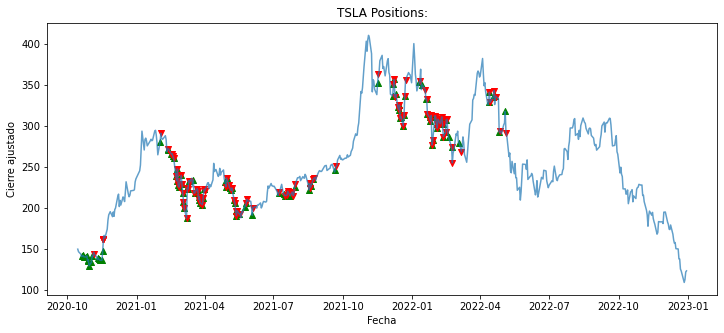

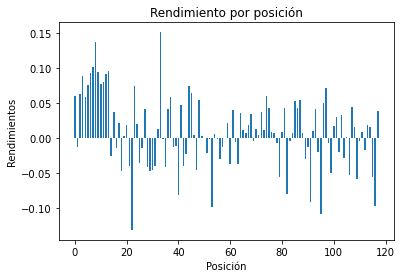

,Rendimientos,Utilidad,Monto
0,0.060681,0.058181,1058181.359
1,-0.013170,-0.015670,1041599.846
2,0.062844,0.060344,1104453.896
3,0.089206,0.086706,1200216.952
4,0.058028,0.055528,1266862.790
...,...,...,...
113,0.018561,0.016061,1959649.950
114,0.016208,0.013708,1986512.376
115,-0.055660,-0.058160,1870975.831
116,-0.097295,-0.099795,1684262.522


'Victorias: 0.576'

'Victoria promedio: 0.041'

'Perdida promedio: -0.036'

'Balance: 1570873.059'

'Utilidad: 0.571'

In [34]:
# Elegir activo:
stock = 'TSLA'

# Generar dataframe y calcular señales de compra:
frame = RSIcalc(stock)
#Buy, Sell = getSignals(frame)
Buy, Sell = getSignals2(frame, -0.1)

# Calcular retornos de estrategia
Profits = (frame.loc[Sell].Open.values - frame.loc[Buy].Open.values)/(frame.loc[Buy].Open.values)

# Delimitar costos de mercado y capital inicial
Comisiones = 0.0025
capital = 1000000

# Generar dataframe de retornos y utilidades
dfr = pd.DataFrame()
dfr['Rendimientos'] = Profits
dfr['Utilidad'] = dfr['Rendimientos']-Comisiones

# Generar columna de MONTO e INTERÉS COMPUESTO
Monto = [capital]

for i in range(len(dfr)):
    valor = Monto[-1]*(1+dfr['Utilidad'][i])
    Monto.append(valor)

    # se borra capital inicial de la lista de montos
del Monto[0]
dfr['Monto'] = np.round(Monto,3)

# Graficamos cierre de activo con fechas de compra:
plt.figure(figsize=(12,5))
plt.scatter(frame.loc[Buy].index , frame.loc[Buy]['Adj Close'], marker='^',c='g')
plt.scatter(frame.loc[Sell].index , frame.loc[Sell]['Adj Close'], marker='v',c='r')
plt.plot(frame['Adj Close'], alpha=0.7)
plt.xlabel('Fecha')
plt.ylabel('Cierre ajustado')
plt.title(str(stock)+ ' Positions:')
plt.show()

# Graficamos retorno generado por número de posición:
plt.bar(dfr.index, dfr.Rendimientos,width=0.6)
plt.xlabel("Posición")
plt.ylabel("Rendimientos")
plt.title("Rendimiento por posición")
plt.show()

# Calculamos el número de victorias en la estrategia:
wins = [i for i in Profits if i > 0]
avrg_win = np.mean(wins)
wins = len(wins)/len(Profits)

loss = [i for i in Profits if i < 0]
avrg_loss = np.mean(loss)

# Calculamos utilidad final DESPUÉS DE IMPUESTOS
impuestos = 0.1
    
    # Encontramos monto final
ultimo = dfr[['Monto']].iloc[-1]
    
    # Restamos impuestos
ultimo_TSLA = ultimo * (1-impuestos)
    
    # Lo convertimos en tasa comparado al capital inicial
utilidad_TSLA = (ultimo_TSLA - capital) / capital
    
# Mandamos todo a proyectar en la misma celda
display(dfr, 
        'Victorias: '+str(np.round(wins,3)),
        'Victoria promedio: ' +str(np.round(avrg_win,3)),
        'Perdida promedio: '+str(np.round(avrg_loss,3)),
        'Balance: '+str(np.round(ultimo_TSLA,3)[0]),
        'Utilidad: ' +str(np.round(utilidad_TSLA,3)[0]))

[*********************100%***********************]  1 of 1 completed


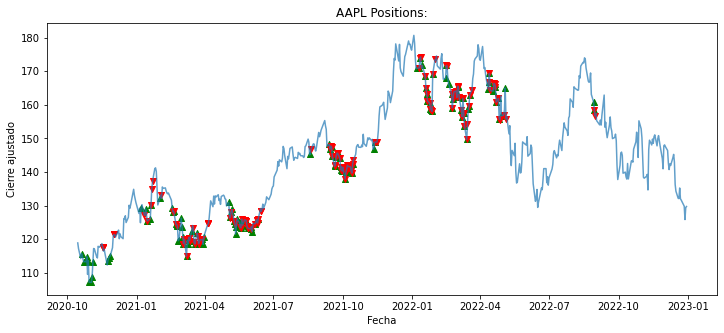

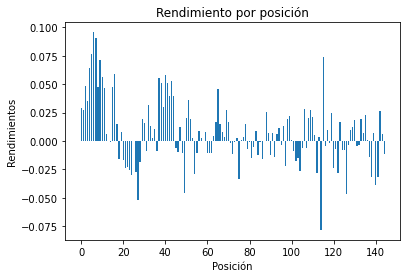

,Rendimientos,Utilidad,Monto
0,0.028830,0.026330,1026329.657
1,0.027150,0.024650,1051628.817
2,0.048592,0.046092,1100100.741
3,0.035155,0.032655,1136024.095
4,0.063896,0.061396,1205771.497
...,...,...,...
140,-0.039075,-0.041575,1888195.832
141,-0.031698,-0.034198,1823623.481
142,0.026179,0.023679,1866805.142
143,0.006081,0.003581,1873490.842


'Victorias: 0.566'

'Victoria promedio: 0.025'

'Perdida promedio: -0.016'

'Balance: 1662998.442'

'Utilidad: 0.663'

In [35]:
# Elegir activo:
stock = 'AAPL'

# Generar dataframe y calcular señales de compra:
frame = RSIcalc(stock)
#Buy, Sell = getSignals(frame)
Buy, Sell = getSignals2(frame, -0.1)

# Calcular retornos de estrategia
Profits = (frame.loc[Sell].Open.values - frame.loc[Buy].Open.values)/(frame.loc[Buy].Open.values)

# Delimitar costos de mercado y capital inicial
Comisiones = 0.0025
capital = 1000000

# Generar dataframe de retornos y utilidades
dfr = pd.DataFrame()
dfr['Rendimientos'] = Profits
dfr['Utilidad'] = dfr['Rendimientos']-Comisiones

# Generar columna de MONTO e INTERÉS COMPUESTO
Monto = [capital]

for i in range(len(dfr)):
    valor = Monto[-1]*(1+dfr['Utilidad'][i])
    Monto.append(valor)

    # se borra capital inicial de la lista de montos
del Monto[0]
dfr['Monto'] = np.round(Monto,3)

# Graficamos cierre de activo con fechas de compra:
plt.figure(figsize=(12,5))
plt.scatter(frame.loc[Buy].index , frame.loc[Buy]['Adj Close'], marker='^',c='g')
plt.scatter(frame.loc[Sell].index , frame.loc[Sell]['Adj Close'], marker='v',c='r')
plt.plot(frame['Adj Close'], alpha=0.7)
plt.xlabel('Fecha')
plt.ylabel('Cierre ajustado')
plt.title(str(stock)+ ' Positions:')
plt.show()

# Graficamos retorno generado por número de posición:
plt.bar(dfr.index, dfr.Rendimientos,width=0.6)
plt.xlabel("Posición")
plt.ylabel("Rendimientos")
plt.title("Rendimiento por posición")
plt.show()

# Calculamos el número de victorias en la estrategia:
wins = [i for i in Profits if i > 0]
avrg_win = np.mean(wins)
wins = len(wins)/len(Profits)

loss = [i for i in Profits if i < 0]
avrg_loss = np.mean(loss)

# Calculamos utilidad final DESPUÉS DE IMPUESTOS
impuestos = 0.1
    
    # Encontramos monto final
ultimo = dfr[['Monto']].iloc[-1]
    
    # Restamos impuestos
ultimo_AAPL = ultimo * (1-impuestos)
    
    # Lo convertimos en tasa comparado al capital inicial
utilidad_AAPL = (ultimo_AAPL - capital) / capital
    
# Mandamos todo a proyectar en la misma celda
display(dfr, 
        'Victorias: '+str(np.round(wins,3)),
        'Victoria promedio: ' +str(np.round(avrg_win,3)),
        'Perdida promedio: '+str(np.round(avrg_loss,3)),
        'Balance: '+str(np.round(ultimo_AAPL,3)[0]),
        'Utilidad: ' +str(np.round(utilidad_AAPL,3)[0]))

[*********************100%***********************]  1 of 1 completed


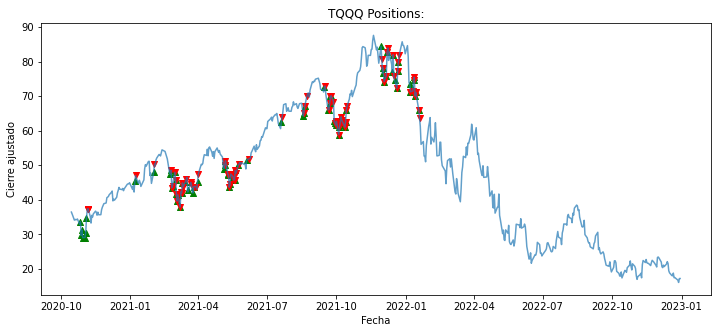

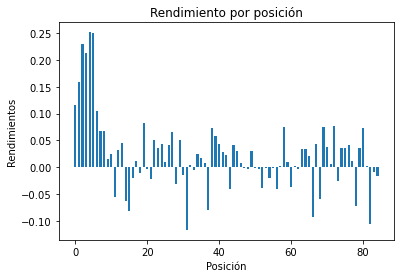

,Rendimientos,Utilidad,Monto
0,0.116184,0.113684,1113683.737
1,0.158013,0.155513,1286875.647
2,0.229047,0.226547,1578413.474
3,0.213031,0.210531,1910718.586
4,0.251106,0.248606,2385734.790
...,...,...,...
80,0.073485,0.070985,5408760.006
81,0.001883,-0.000617,5405425.181
82,-0.104240,-0.106740,4828452.200
83,-0.008684,-0.011184,4774449.327


'Victorias: 0.635'

'Victoria promedio: 0.056'

'Perdida promedio: -0.034'

'Balance: 4215366.814'

'Utilidad: 3.215'

In [36]:
# Elegir activo:
stock = 'TQQQ'

# Generar dataframe y calcular señales de compra:
frame = RSIcalc(stock)
#Buy, Sell = getSignals(frame)
Buy, Sell = getSignals2(frame, -0.1)

# Calcular retornos de estrategia
Profits = (frame.loc[Sell].Open.values - frame.loc[Buy].Open.values)/(frame.loc[Buy].Open.values)

# Delimitar costos de mercado y capital inicial
Comisiones = 0.0025
capital = 1000000

# Generar dataframe de retornos y utilidades
dfr = pd.DataFrame()
dfr['Rendimientos'] = Profits
dfr['Utilidad'] = dfr['Rendimientos']-Comisiones

# Generar columna de MONTO e INTERÉS COMPUESTO
Monto = [capital]

for i in range(len(dfr)):
    valor = Monto[-1]*(1+dfr['Utilidad'][i])
    Monto.append(valor)

    # se borra capital inicial de la lista de montos
del Monto[0]
dfr['Monto'] = np.round(Monto,3)

# Graficamos cierre de activo con fechas de compra:
plt.figure(figsize=(12,5))
plt.scatter(frame.loc[Buy].index , frame.loc[Buy]['Adj Close'], marker='^',c='g')
plt.scatter(frame.loc[Sell].index , frame.loc[Sell]['Adj Close'], marker='v',c='r')
plt.plot(frame['Adj Close'], alpha=0.7)
plt.xlabel('Fecha')
plt.ylabel('Cierre ajustado')
plt.title(str(stock)+ ' Positions:')
plt.show()

# Graficamos retorno generado por número de posición:
plt.bar(dfr.index, dfr.Rendimientos,width=0.6)
plt.xlabel("Posición")
plt.ylabel("Rendimientos")
plt.title("Rendimiento por posición")
plt.show()

# Calculamos el número de victorias en la estrategia:
wins = [i for i in Profits if i > 0]
avrg_win = np.mean(wins)
wins = len(wins)/len(Profits)

loss = [i for i in Profits if i < 0]
avrg_loss = np.mean(loss)

# Calculamos utilidad final DESPUÉS DE IMPUESTOS
impuestos = 0.1
    
    # Encontramos monto final
ultimo = dfr[['Monto']].iloc[-1]
    
    # Restamos impuestos
ultimo_TQQQ = ultimo * (1-impuestos)
    
    # Lo convertimos en tasa comparado al capital inicial
utilidad_TQQQ = (ultimo_TQQQ - capital) / capital
    
# Mandamos todo a proyectar en la misma celda
display(dfr, 
        'Victorias: '+str(np.round(wins,3)),
        'Victoria promedio: ' +str(np.round(avrg_win,3)),
        'Perdida promedio: '+str(np.round(avrg_loss,3)),
        'Balance: '+str(np.round(ultimo_TQQQ,3)[0]),
        'Utilidad: ' +str(np.round(utilidad_TQQQ,3)[0]))

In [37]:
cap_total = capital*4
suma_montos = ultimo_MSFT + ultimo_TSLA + ultimo_AAPL + ultimo_TQQQ
utilidad_total = (suma_montos - cap_total) / cap_total
np.round(utilidad_total,3)

Monto    1.587
dtype: float64